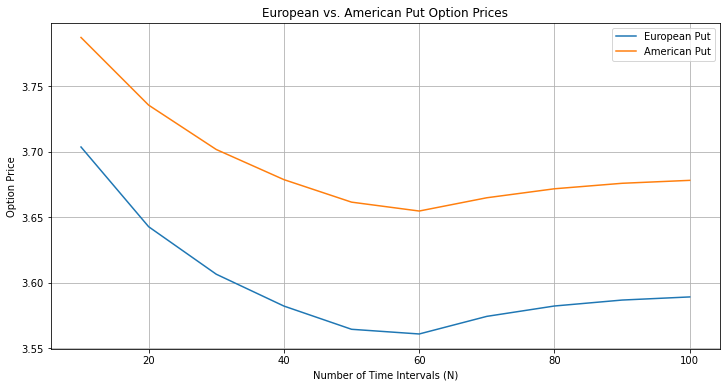

In [3]:
import numpy as np

# Define the parameters
S = 54  # Spot price
K = 50  # Strike price
T = 1  # Time to expiration
q = 0.01  # Dividend yield (continuously compounded)
sigma = 0.29  # Volatility
r = 0.0375  # Risk-free interest rate

# Define the number of time intervals (N)
N_values = np.arange(10, 101, 10)

# Initialize arrays to store option prices for each method
european_put_prices = []
american_put_prices = []

for N in N_values:
    # Calculate delta t (δt)
    delta_t = T / N

    # Calculate u and d
    u = np.exp(sigma * np.sqrt(delta_t))
    d = 1 / u

    # Calculate pRN
    pRN = (np.exp((r - q) * delta_t) - d) / (u - d)

    # Initialize arrays to store option values at each node
    european_option_values = np.zeros(N + 1)
    american_option_values = np.zeros(N + 1)

    # Calculate option values at expiration (European and American are the same at expiration)
    for i in range(N + 1):
        S_t = S * (u ** (N - i)) * (d ** i)
        european_option_values[i] = max(0, K - S_t)
        american_option_values[i] = max(0, K - S_t)

    # Calculate option values at earlier time steps
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            S_t = S * (u ** (j - i)) * (d ** i)
            european_option_values[i] = np.exp(-r * delta_t) * (pRN * european_option_values[i] + (1 - pRN) * european_option_values[i + 1])
            american_option_values[i] = max(K - S_t, np.exp(-r * delta_t) * (pRN * american_option_values[i] + (1 - pRN) * american_option_values[i + 1]))

    # Store option prices for this N in the respective arrays
    european_put_prices.append(european_option_values[0])
    american_put_prices.append(american_option_values[0])

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(N_values, european_put_prices, label='European Put')
plt.plot(N_values, american_put_prices, label='American Put')
plt.xlabel('Number of Time Intervals (N)')
plt.ylabel('Option Price')
plt.title('European vs. American Put Option Prices')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import math

# Given option information
S0 = 58  # Spot price
K = 60   # Strike price
T = 9/12  # Time to maturity (9 months)
r = 0.02  # Risk-free interest rate
q = 0.01  # Dividend rate
option_price = 6.36  # Given option price
tolerance = 1e-4  # Tolerance level for convergence
max_steps = 1000  # Maximum number of steps to avoid infinite loop

# Initialize variables
N = 10  # Initial number of time steps
prev_volatility = 0  # Initialize previous volatility

while N < max_steps:
    # Calculate the trinomial tree option price for the current N
    dt = T / N
    u = math.exp(math.sqrt((r - q)**2 * dt))
    d = 1 / u
    q = (math.exp((r - q) * dt) - d) / (u - d)
    
    # Initialize variables for the trinomial tree calculation
    option_tree = [[0 for _ in range(N + 1)] for _ in range(N + 1)]
    
    # Calculate option prices at expiration
    for i in range(N + 1):
        option_tree[N][i] = max(0, K - S0 * (u**i) * (d**(N - i)))
    
    # Backward induction to calculate option prices at earlier times
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            option_tree[j][i] = math.exp(-r * dt) * (q * option_tree[j + 1][i] + (1 - q) * option_tree[j + 1][i + 1])
    
    # Calculate the implied volatility using the Black-Scholes formula
    def black_scholes(volatility):
        d1 = (math.log(S0 / K) + ((r - q + 0.5 * (volatility**2)) * T)) / (volatility * math.sqrt(T))
        d2 = d1 - volatility * math.sqrt(T)
        return S0 * math.exp(-q * T) * norm.cdf(-d2) - K * math.exp(-r * T) * norm.cdf(-d1)
    
    # Calculate the current implied volatility
    from scipy.stats import norm
    implied_volatility = 0.05  # Initial guess
    option_price_tree = option_tree[0][0]
    while True:
        implied_price = black_scholes(implied_volatility)
        if abs(option_price_tree - implied_price) < tolerance:
            break
        implied_volatility -= (implied_price - option_price_tree) / black_scholes(implied_volatility + 0.001)  # Secant method
    
    # Check for convergence
    if abs(implied_volatility - prev_volatility) < tolerance:
        break
    
    prev_volatility = implied_volatility
    N *= 2  # Double the time steps for the next iteration

# Print the result
print(f"Implied Volatility: {implied_volatility:.6f}")
print(f"Number of Time Steps (Nfixed): {N}")
